In [1]:
'''
Primary author: Jiying Zou, Jong Ha Lee
Purpose: Take subsetted CT scans (from subsample_raw_data.py) and create ordered, interpolated 3D volumes for scans with 30-50 slices
Notes: This script is meant to be run after subsample_raw_data.py (which itself should only be run once)
Code credits: Lines 29-67 adapted from a Kaggle notebook https://www.kaggle.com/anjum48/reconstructing-3d-volumes-from-metadata
              Code credits for functions used are separately specified in the function files.
'''

import pandas as pd
import numpy as np
from scipy import ndimage
import os
from sys import getsizeof
import joblib
import random
import sys
import webdataset as wds
import json
# import pydicom
# from tqdm import tqdm_notebook
import matplotlib.pylab as plt
%matplotlib inline

sys.path.append('..') # may need to change to '.' if cannot find data_path, depends on what your current working directory is

from utils.get_metadata import *
#from utils.window import window_img
from utils.create_3D_volume import *
from utils.resize_volume import *

random.seed(231)

In [2]:
# Set file paths 
data_path = '/home/jupyter/ICH_detection/data/stage_2_train'
metadata_path = data_path
label_path = '/home/jupyter/ICH_detection/data/stage_2_train.csv'

In [3]:
# Prepare labels and metadata (for each image, is ICH present? if so, what type?)
train_df = pd.read_csv(f'{label_path}').drop_duplicates()
train_df['ImageID'] = train_df['ID'].str.slice(stop=12)
train_df['Diagnosis'] = train_df['ID'].str.slice(start=13)
train_labels = train_df.pivot(index="ImageID", columns="Diagnosis", values="Label")

In [4]:
# Generate metadata dataframe
#train_metadata = get_metadata(data_path)
#train_metadata["Dataset"] = "train"

# Save metadata dataframe (only have to do this once since it takes a while, results are saved)
#train_metadata.to_parquet(f'{metadata_path}/train_metadata.parquet.gzip', compression='gzip')

In [5]:
# Load metadata dataframe
train_metadata = pd.read_parquet(f'{metadata_path}/train_metadata.parquet.gzip')

# Join image metadata with outcome labels
metadata = train_metadata.join(train_labels)

# Organize the scans (top-down order)
metadata.sort_values(by="ImagePositionPatient_2", inplace=True, ascending=False) # sort so images are in top-down order

# Count the number of CT scans
print("There are ", metadata["StudyInstanceUID"].nunique(), " CT scans in the subsampled dataset.")

There are  3386  CT scans in the subsampled dataset.


Distribution of number of slices per scan:
count    3386.000000
mean       34.445363
std         5.139599
min        20.000000
25%        32.000000
50%        33.000000
75%        37.000000
max        60.000000
dtype: float64


(array([   4.,   26.,  679., 1437.,  613.,  422.,  113.,   43.,   29.,
          20.]),
 array([20., 24., 28., 32., 36., 40., 44., 48., 52., 56., 60.]),
 <BarContainer object of 10 artists>)

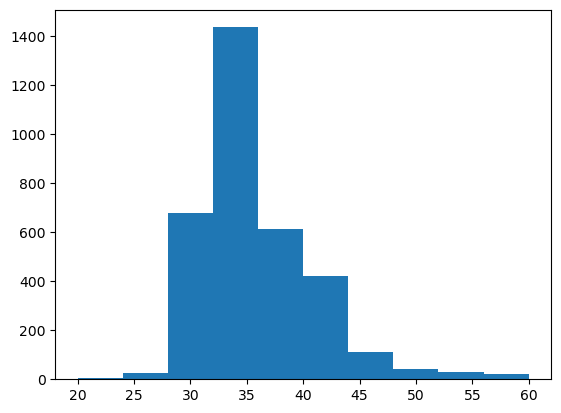

In [6]:
# Group together all images per scan
studies = metadata.groupby("StudyInstanceUID")
studies_list = list(studies)

## Descriptive statistics on num slices per scan
print("Distribution of number of slices per scan:")
print(studies.size().describe())

## Visualization for num slices per scan
plt.hist(studies.size())

In [7]:
# Subset for just the scans with 30-40 slices (histogram-driven cutoff)
# (Some clinical-practice considerations for num images per scan can be found here: https://www.reddit.com/r/askscience/comments/7cruuv/how_many_images_does_a_ct_scan_produce/)
studies_list_mod = [study for study in studies_list if study[1].shape[0] in range(30, 41)]

# How many unique studies (CT scans) are we dealing with?
# print("After subsetting for CT scans with 30-50 slices, we are left with ", len(set(studies_list_mod)), " unique scans.")

In [8]:
# Set up shard writer

## data directory to write shards to 
write_dir = "../data/"

## load parameters by opening JSON file
with open('../parameters.json') as json_file:
    parameters = json.load(json_file)

In [10]:
# Create 3D volumes for all the scans
# and write them to shards in batches of 32 (https://github.com/webdataset/webdataset/blob/master/webdataset/writer.py)
# (Also does data NORMALIZATION and L/R FLIPS with probability 0.5, and keeps track of largest dimensions for interpolation later on)
# (Not doing rotations or up-down flips or crops since CT scans are usually all front side up and full-brain-cross-section anyways)

study_names_all = []
volumes_all = []
labels_all = []
labels_record = [] # to help tally samples at the end

#largest_depth = 0
#largest_width = 0
#largest_height = 0

flip_prob = 0.5

print("Creating 3D volumes.........")
with wds.ShardWriter(os.path.join(write_dir, 'shards', 'shard-%06d.tar'), maxcount=parameters['batch_size']) as sink: # file pattern, max number of things written to shard
    # ^ when you create a new ShardWriter, the indexing for written output files starts over from 0, which is why we can't have this initialized over and over again within the loop
    # (https://github.com/webdataset/webdataset/blob/master/webdataset/writer.py)
    
    for i in range(0, len(studies_list_mod)):

      # Get study
      study_name, study_df = studies_list_mod[i]

      # Create 3D volume (normalizes)
      volume, labels = create_3D_volume(study_df, data_path) # label returned is just a length=6 list containing 0/1 for any ICH / ICH type

      # L/R flip with prob = 0.5
      #volume2 = None
      if np.all(np.random.uniform(0, 1, size = 1)) > flip_prob:
          volume = volume[:, :, ::-1]

      # Interpolate to (40, 512, 512)
      volume = resize_volume(volume, 40, 512, 512) # max data size (40, 512, 512)

      # Store results
      study_names_all.append(study_name)
      volumes_all.append(volume)
      labels_all.append(labels)
      labels_record.append(labels)

      #if volume2 is not None:
      #  study_names_all.append(study_name + "_flip")
      #  volumes_all.append(volume2)
      #  labels_all.append(labels)
      #  labels_record.append(labels)

      # Save results to shard every 32nd image to clear out RAM
      if i % 32 == 0 and i > 0:
        for idx in range(len(study_names_all)):
            sink.write({
                '__key__': "%06d"%idx, # the index within each shard -- e.g. data point 33 would be in shard 2 with key value 1
                'volumes.pyd': volumes_all[idx],
                'labels.pyd': labels_all[idx],
                'studynames.pyd': np.array([study_names_all[idx]])
                })
    
        #print(getsizeof(study_names_all))
        #print(getsizeof(volumes_all))
        #print(getsizeof(labels_all))

        # Save pickled files
        #studynames_filename = '../data/CTscans_studynames_train_{}.sav'.format(i)
        #joblib.dump(study_names_all, studynames_filename)  

        #volumes_filename = '../data/CTscans_3Dvolumes_interp_train_{}'.format(i)
        #joblib.dump(volumes_all, volumes_filename) 

        #labels_filename = '../data/CTscans_3Dlabels_train_{}'.format(i)
        #joblib.dump(labels_all, labels_filename) 

        # Clear out working memory
        study_names_all = []
        volumes_all = []
        labels_all = []

      if i % 100 == 0:
        print("On scan #" + str(i+1))
        
      # Update largest depth, width, height
      #shape = volume.shape
      #if shape[0] > largest_depth:
      #  largest_depth = shape[0]
      #if shape[1] > largest_width:
      #  largest_width = shape[1]
      #if shape[2] > largest_height:
      #  largest_height = shape[2]

print("DONE!")
#print("Largest depth, width, height are: " + str(largest_depth) + ", " + str(largest_width) + ", " + str(largest_height))
# corrupted file somewhere around 1501-1601

Creating 3D volumes.........
# writing ../data/shards/shard-000000.tar 0 0.0 GB 0
On scan #1
# writing ../data/shards/shard-000001.tar 32 2.7 GB 32
# writing ../data/shards/shard-000002.tar 32 2.7 GB 64
# writing ../data/shards/shard-000003.tar 32 2.7 GB 96
On scan #101
# writing ../data/shards/shard-000004.tar 32 2.7 GB 128
# writing ../data/shards/shard-000005.tar 32 2.7 GB 160
# writing ../data/shards/shard-000006.tar 32 2.7 GB 192
On scan #201
# writing ../data/shards/shard-000007.tar 32 2.7 GB 224
# writing ../data/shards/shard-000008.tar 32 2.7 GB 256
# writing ../data/shards/shard-000009.tar 32 2.7 GB 288
On scan #301
# writing ../data/shards/shard-000010.tar 32 2.7 GB 320
# writing ../data/shards/shard-000011.tar 32 2.7 GB 352
# writing ../data/shards/shard-000012.tar 32 2.7 GB 384
On scan #401
# writing ../data/shards/shard-000013.tar 32 2.7 GB 416
# writing ../data/shards/shard-000014.tar 32 2.7 GB 448
# writing ../data/shards/shard-000015.tar 32 2.7 GB 480
On scan #501
# wri

ValueError: The length of the pixel data in the dataset (153710 bytes) doesn't match the expected length (524288 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

In [6]:
# First-order spline interpolation (so that data is all of same size)
# Don't need this anymore, interpolation happening within loop above
# print("Adjusting all scans to be of same size.............")

# for i in range(*{'start':100,'stop':200,'step':100}.values()): # change to number of data files
#   print("On scan #" + str(i+1))

#   # read the saved data files 
#   volumes_filename = '../data/CTscans_3Dvolumes_train_{}'.format(i)
#   volumes_all = joblib.load(volumes_filename) 

#   volumes_all_interp = []
#   # resize the volumes one by one (another loop) and save into intermediate list
#   for vol in volumes_all:
#     resized_volume = resize_volume(vol, largest_depth, largest_width, largest_height)
#     volumes_all_interp.append(resized_volume)

#   # save interpolated volumes
#     interpvolumes_filename = '../data/CTscans_3Dvolumes_interp_train_{}'.format(i)
#     joblib.dump(volumes_all_interp, interpvolumes_filename) 

# print("DONE!")

Adjusting all scans to be of same size.............
On scan #101


MemoryError: Unable to allocate 64.0 MiB for an array with shape (8388608,) and data type float64

# SOME EDA

In [34]:
# Check how many scans of each type we have in our dataset
print("There are {} scans total in the dataset.\n".format(len(labels_record)))

print("Out of these, there are {0} scans with no ICH at all and {1} with some type of ICH.\n".format(np.sum([1 for x in labels_record if x[0] == 0]), np.sum([1 for x in labels_record if x[0] == 1])))
print("To make sure that there are no scans that say no ICH but still have some type of ICH indicator, the following number should be the same as number of scans with no ICH: {}\n".format(np.sum([1 for x in labels_record if x[0] == 0 and all(i == 0 for i in x[1:])])))

print("Out of scans with ICH, there are {0} with epidural ICH, {1} with intraparenchymal ICH,\n {2} with intraventricular ICH, {3} with subarachnoid ICH, and {4} with subdural ICH.\n".format(\
np.sum([1 for x in labels_record if x[1] == 1]),
np.sum([1 for x in labels_record if x[2] == 1]),
np.sum([1 for x in labels_record if x[3] == 1]),
np.sum([1 for x in labels_record if x[4] == 1]),
np.sum([1 for x in labels_record if x[5] == 1])))

print("{} scans have two or more types of ICH present.".format(np.sum([1 for x in labels_record if np.sum(x[1:]) > 1])))
print("{} scans have three or more types of ICH present.".format(np.sum([1 for x in labels_record if np.sum(x[1:]) > 2])))
print("{} scans have four or more types of ICH present.".format(np.sum([1 for x in labels_record if np.sum(x[1:]) > 3])))
print("{} scans have all five types of ICH present.".format(np.sum([1 for x in labels_record if np.sum(x[1:]) > 4])))

There are 1554 scans total in the dataset.

Out of these, there are 516 scans with no ICH at all and 1038 with some type of ICH.

To make sure that there are no scans that say no ICH but still have some type of ICH indicator, the following number should be the same as number of scans with no ICH: 516

Out of scans with ICH, there are 124 with epidural ICH, 629 with intraparenchymal ICH,
 470 with intraventricular ICH, 519 with subarachnoid ICH, and 485 with subdural ICH.

709 scans have two or more types of ICH present.
366 scans have three or more types of ICH present.
108 scans have four or more types of ICH present.
6 scans have all five types of ICH present.
